In [1]:
#%matplotlib inline
#%matplotlib widget

import numpy as np
from matplotlib import pyplot as plt
import os.path as osp
import xarray as xr
import sys
import os
import glob
import pickle5 as pickle
import cartopy.crs as ccrs
import geopandas as gpd
import pandas as pd
import geoplot as gplt
import geoplot.crs as gcrs
from shapely.geometry import Polygon, Point, LineString
from shapely.ops import cascaded_union
import imageio
from pvlib import solarposition

import birds

In [2]:
from birds import *

In [3]:
root = '/home/fiona/birdMigration/data'
radar_path = osp.join(root, 'raw', 'radar', 'fall', '2015')
radars = datahandling.load_radars(radar_path)
sp = spatial.Spatial(radars)

NameError: name 'datahandling' is not defined

In [4]:
d = '/home/fiona/birdMigration/data/shapes'
countries = gpd.read_file(osp.join(d, 'ne_10m_admin_0_countries_lakes.shp'))
departure_area = gpd.read_file(osp.join(d, 'departure_area.shp'))

In [3]:
abm_dir = '/home/fiona/birdMigration/data/raw/abm/fall/2015'
files = glob.glob(os.path.join(abm_dir, '*.pkl'))

with open(files[0], 'rb') as f:
    result = pickle.load(f)
    traj = result['trajectories']
    states = result['states']

NameError: name 'traj' is not defined

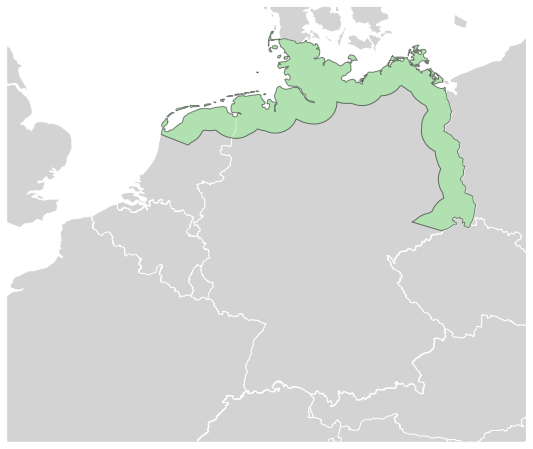

In [5]:
def background_map():
    extent=[0.36, 46.36, 16.07, 55.40]
    ax = gplt.polyplot(
      countries,
      edgecolor="white",
      facecolor="lightgray",
      figsize=(12, 8),
      projection=gcrs.AlbersEqualArea(),
      extent=extent
    )
    ax = gplt.polyplot(
        departure_area, 
        facecolor="lightgreen",
        alpha=0.5,
        ax=ax, zorder=1,
        extent=extent
    )
    return ax, extent

def draw_birds(traj, states, anim_path, tidx, time):
    ax, extent = background_map()
    
    flying = np.where(states==1)
    ground = np.where(states==0)
    if len(flying[0]) > 0:
        xx = traj[flying, 0].flatten()
        yy = traj[flying, 1].flatten()
        df = gpd.GeoSeries(gpd.points_from_xy(xx, yy, crs='epsg:4326'))
        gplt.pointplot(df, ax=ax, extent=extent, zorder=1, color='red', alpha=0.8)
        #points = [Point(x, y) for x,y in zip(xx, yy)]
        #gplt.pointplot(gpd.GeoSeries(points, crs='epsg:4326'), ax=ax, extent=extent, zorder=1, color='red', alpha=0.8)
    if len(ground[0]) > 0:
        xx = traj[ground, 0].flatten()
        yy = traj[ground, 1].flatten()
        points = [Point(x, y) for x,y in zip(xx, yy)]
        gplt.pointplot(gpd.GeoSeries(points, crs='epsg:4326'), ax=ax, extent=extent, zorder=2, color='blue', alpha=0.2)

    ax.set_title(time)
    file_name = osp.join(anim_path, f'{tidx}.png')
    plt.savefig(file_name, bbox_inches="tight", pad_inches=0.1)
    plt.close()
    return file_name

ax, extent = background_map()
for bidx in range(8):
    xx = traj[:,bidx,0]
    yy = traj[:,bidx,1]
    tr = LineString([Point(x, y) for x,y in zip(xx, yy)])
    start = Point(xx[0], yy[0])
    stopovers = [Point(x, y) for t, (x,y) in enumerate(zip(xx, yy)) if states[t, bidx]==0]
    gplt.polyplot(gpd.GeoSeries(tr, crs='epsg:4326'), ax=ax, zorder=2, extent=extent)
    gplt.pointplot(gpd.GeoSeries(stopovers, crs='epsg:4326'), ax=ax, zorder=3, extent=extent, edgecolor='black', color='white', linewidth=0.5)
    gplt.pointplot(gpd.GeoSeries(start, crs='epsg:4326'), ax=ax, zorder=3, extent=extent, color='red')
    
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
plt.savefig('/home/fiona/birdMigration/data/raw/abm/fall/2015/example_trajectories.png', dpi=300)

In [220]:
with open('/home/fiona/birdMigration/data/model_performance/test_gnn3/outfluxes_linear+sigmoid.pickle', 'rb') as f:
    outfluxes = pickle.load(f)
len(outfluxes)

91

outfluxes for radar DE/FLD
DE/MEM tensor(0.)
DE/ISN tensor(0.)
DE/ESS tensor(0.0417)
DE/PRO tensor(0.)
DE/OFT tensor(0.1754)
DE/TUR tensor(0.)
DE/UMD tensor(0.0005)
BE/ZAV tensor(0.)
DE/EIS tensor(0.)
DE/FBG tensor(0.)
DE/NEU tensor(0.0002)
DE/NHB tensor(0.)
DE/HNR tensor(0.0033)
DE/ROS tensor(0.)
BE/WID tensor(0.)
BE/JAB tensor(0.)
DE/FLD tensor(0.9070)
DE/BOO tensor(0.)
DE/EMD tensor(0.)
DE/DRS tensor(0.)
NL/DBL tensor(0.)
NL/DHL tensor(0.)
(array([ 2,  4,  6, 10, 12, 16]),)


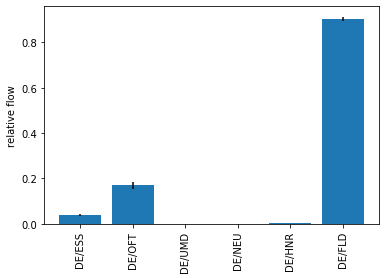

In [258]:
import torch
files = glob.glob(os.path.join('/home/fiona/birdMigration/data/raw/radar/fall/2015', '*.nc'))
radars = [xr.open_dataset(f).source for f in files]

r = 16
t=46
print(f'outfluxes for radar {radars[r]}')
for i, f in enumerate(outfluxes[t][r, :, 4]):
    print(radars[i], f.detach())

all_fluxes = []
for n in range(len(outfluxes)):
    for t in range(5):
        all_fluxes.append(outfluxes[n][r, :, t])
means = torch.stack(all_fluxes, -1).mean(-1).detach().numpy()
std = torch.stack(all_fluxes, -1).std(-1).detach().numpy()

idx = np.where(means > 0)
print(idx)
neighbors = np.array(radars)[idx]
x = np.arange(neighbors.size)

df = pd.DataFrame()
for i, r in enumerate(radars):
    df[r] = torch.stack(all_fluxes, -1)[i].detach().numpy()
    
fig, ax = plt.subplots()
ax.bar(x, means[idx], yerr=std[idx])
#ax.set_xticklabels(neighbors)
plt.xticks(ticks=x, labels=neighbors)
ax.tick_params(axis='x', rotation=90)
ax.set_ylabel('relative flow')
fig.savefig('/home/fiona/birdMigration/data/FLD_flows.png', dpi=300, bbox_inches='tight')

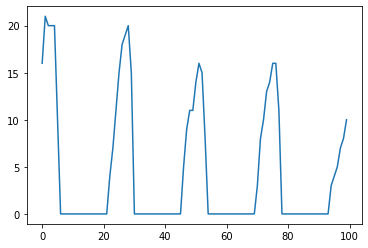

In [20]:
plt.plot(counts.reshape((counts.shape[0], -1)).sum(1))

In [20]:
abm_path = '/home/fiona/birdMigration/data/experiments/abm/fall/2015/experiment_2021-02-17 19:11:34.724467'

traj = []
states = []
for i in range(10):
    with open(osp.join(abm_path, f'simulation_results_{i}.pkl'), 'rb') as f:
        results = pickle.load(f)
    traj.append(results['trajectories'])
    states.append(results['states'])
traj = np.concatenate(traj, axis=1)
states = np.concatenate(states, axis=1)
traj.shape

(1465, 2944, 2)

In [ ]:

fp = osp.join(abm_path, 'animation_test')
os.makedirs(fp, exist_ok=True)
files = []
for tidx in range(50):
    files.append(draw_birds(results['trajectories'][tidx], results['states'][tidx], fp, tidx, results['time'][tidx]));

In [27]:
images = []
for file_name in files:
    images.append(imageio.imread(file_name))
gif_path = osp.join(abm_path, 'movie_5sets.gif')
imageio.mimsave(gif_path, images, fps=8)

(1465, 22) (1465, 22)


/home/fiona/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


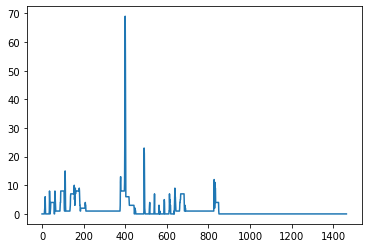

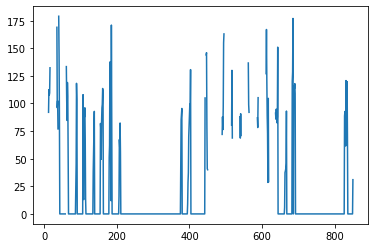

In [41]:
data = []
directions = []
files = glob.glob(os.path.join(abm_path, '*.pkl'))
for file in files:
    with open(file, 'rb') as f:
        result = pickle.load(f)
        data.append(result['counts'])
        directions.append(result['directions'])
        
data = np.stack(data, axis=-1).sum(-1)
directions = np.stack(directions, axis=-1).sum(-1)
directions = np.divide(directions, data)
print(data.shape, directions.shape)
counts = data.sum(1)

# plot total counts over time
fig, ax = plt.subplots()
ax.plot(data[:,0])

fig, ax = plt.subplots()
ax.plot(directions[:,0])

In [5]:
def bird_counts(data, tmin, tmax):
    minx = np.min(data['trajectories'][..., 0])
    miny = np.min(data['trajectories'][..., 1])
    maxx = np.max(data['trajectories'][..., 0])
    maxy = np.max(data['trajectories'][..., 1])
    gridx = np.arange(np.ceil(minx), np.ceil(maxx) + 1, 1)
    gridy = np.arange(np.ceil(miny), np.ceil(maxy) + 1, 1)
    counts = np.zeros((tmax-tmin, gridx.size, gridy.size))

    for bird in range(data['trajectories'].shape[1]):
        xx = np.digitize(data['trajectories'][tmin:tmax, bird, 0], gridx)
        yy = np.digitize(data['trajectories'][tmin:tmax, bird, 1], gridy)
        fidx = np.where(data['states'][tmin:tmax, bird] == 1)
        for t in fidx[0]:
            counts[t, xx[t], yy[t]] += 1

    return counts

In [17]:
counts = bird_counts(results, 400, 500)

In [18]:


import ipywidgets as widgets
from matplotlib import animation
from IPython.display import HTML

fig, ax = plt.subplots()
im = ax.imshow(counts[0])
#plt.colorbar(im)

#@widgets.interact(t=(0, 10, 1))
def animate(t):
    im.set_data(counts[t])
    fig.canvas.draw()
    
widgets.interact(animate, t=widgets.IntSlider(min=0,max=counts.shape[0]-1,step=1,value=0));

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

interactive(children=(IntSlider(value=0, description='t', max=99), Output()), _dom_classes=('widget-interact',…

In [3]:
abm_path = '/home/fiona/birdMigration/data/experiments/abm/fall/2015/experiment_2021-02-17 19:11:34.724467'
abm_path = '/home/fiona/birdMigration/data/experiments/abm/fall/2015/experiment_2021-02-19 15:13:36.750872'

traj = []
states = []
for i in range(10):
    with open(osp.join(abm_path, f'simulation_results_{i}.pkl'), 'rb') as f:
        results = pickle.load(f)
    traj.append(results['trajectories'])
    states.append(results['states'])
    time = results['time']
    
traj = np.concatenate(traj, axis=1)
states = np.concatenate(states, axis=1)
T = states.shape[0]

In [7]:
def make_grid(extent=[0.36, 46.36, 16.07, 55.40], res=0.5, crs='4326'):
    xmin, ymin, xmax, ymax = extent
    cols = np.arange(int(np.floor(xmin))-1, int(np.ceil(xmax))+1, res)
    rows = np.arange(int(np.floor(ymin))-1, int(np.ceil(ymax))+1, res)
    rows = rows[::-1]
    polygons = []
    for x in cols:
        for y in rows:
            polygons.append( Polygon([(x,y), (x+res, y), (x+res, y-res), (x, y-res)]) )

    grid = gpd.GeoDataFrame({'geometry':polygons}, crs=f'epsg:{crs}')
    return grid

def get_points(trajectories, states, state=1):
    df = gpd.GeoDataFrame({'geometry': []}, crs='epsg:4326')
    mask = np.where(states==state)
    if len(mask[0]) > 0:
        xx = trajectories[mask, 0].flatten()
        yy = trajectories[mask, 1].flatten()
        df['geometry'] = gpd.points_from_xy(xx, yy) #, crs='epsg:4326')
    return df

#def get_directions(trajectories, states):
    


def aggregate(traj, states, grid, t_range, state):
    for t in t_range:
        merged = gpd.sjoin(get_points(traj[t], states[t], state), grid, how='left', op='within')
        merged[f'n_birds_{t}'] = 1
        dissolve = merged.dissolve(by="index_right", aggfunc="count")
        grid.loc[dissolve.index, f'n_birds_{t}'] = dissolve[f'n_birds_{t}'].values
    return grid

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

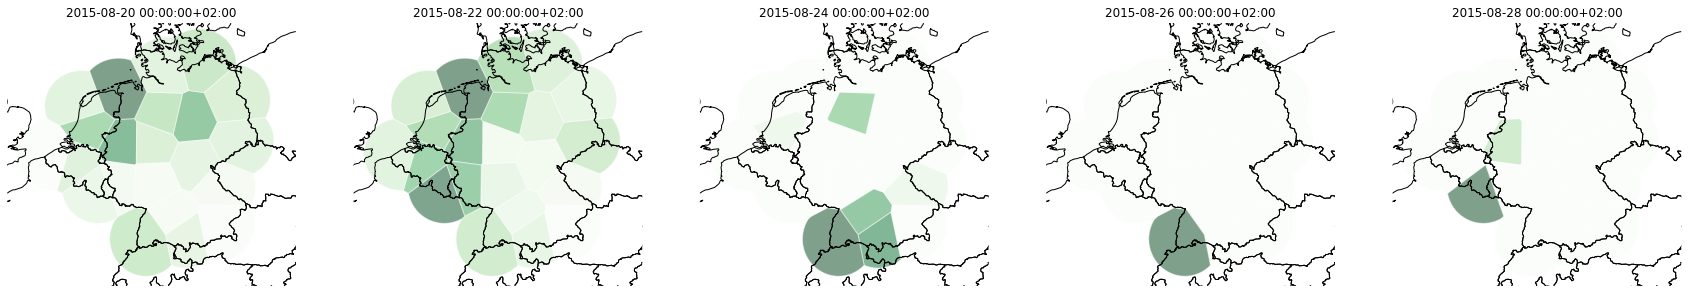

In [68]:
t_range = [104 + dt*2 for dt in range(5)]
grid = make_grid()
grid = gpd.read_file('/home/fiona/birdMigration/data/raw/radar/fall/2015/voronoi.shp').to_crs(epsg='4326')
grid = aggregate(traj, states, grid, t_range, state=1)

fig, axes = plt.subplots(1, len(t_range), figsize=(4*len(t_range), 8), subplot_kw = {'projection' : gcrs.AlbersEqualArea()})
for i, ax in enumerate(axes):
    ax.set_title(results['time'][t_range[i]])
    ax = gplt.polyplot(
      countries,
      ax=ax,
      edgecolor="black",
      extent=extent, zorder=1
    )

    gplt.choropleth(
        grid, hue=f'n_birds_{t_range[i]}',
        edgecolor='white', linewidth=1, ax=ax, alpha=0.5, zorder=0,
        cmap='Greens', legend=False, extent=extent
    );

In [58]:
t_range = range(T)
grid = make_grid()
voronoi = gpd.read_file('/home/fiona/birdMigration/data/raw/radar/fall/2015/voronoi.shp').to_crs(epsg='4326')
counts_vor = aggregate(traj, states, voronoi, t_range, state=1)
counts_vor = counts_vor.fillna(0)

In [59]:
radars = [Point(row.x, row.y).buffer(25_000) for i, row in voronoi.iterrows()]
radars = gpd.GeoDataFrame({'radar': voronoi['radar'], 'geometry': radars}, crs='epsg:3035').to_crs(epsg='4326')
counts_rad = aggregate(traj, states, radars, t_range, state=1)
counts_rad = counts_rad.fillna(0)

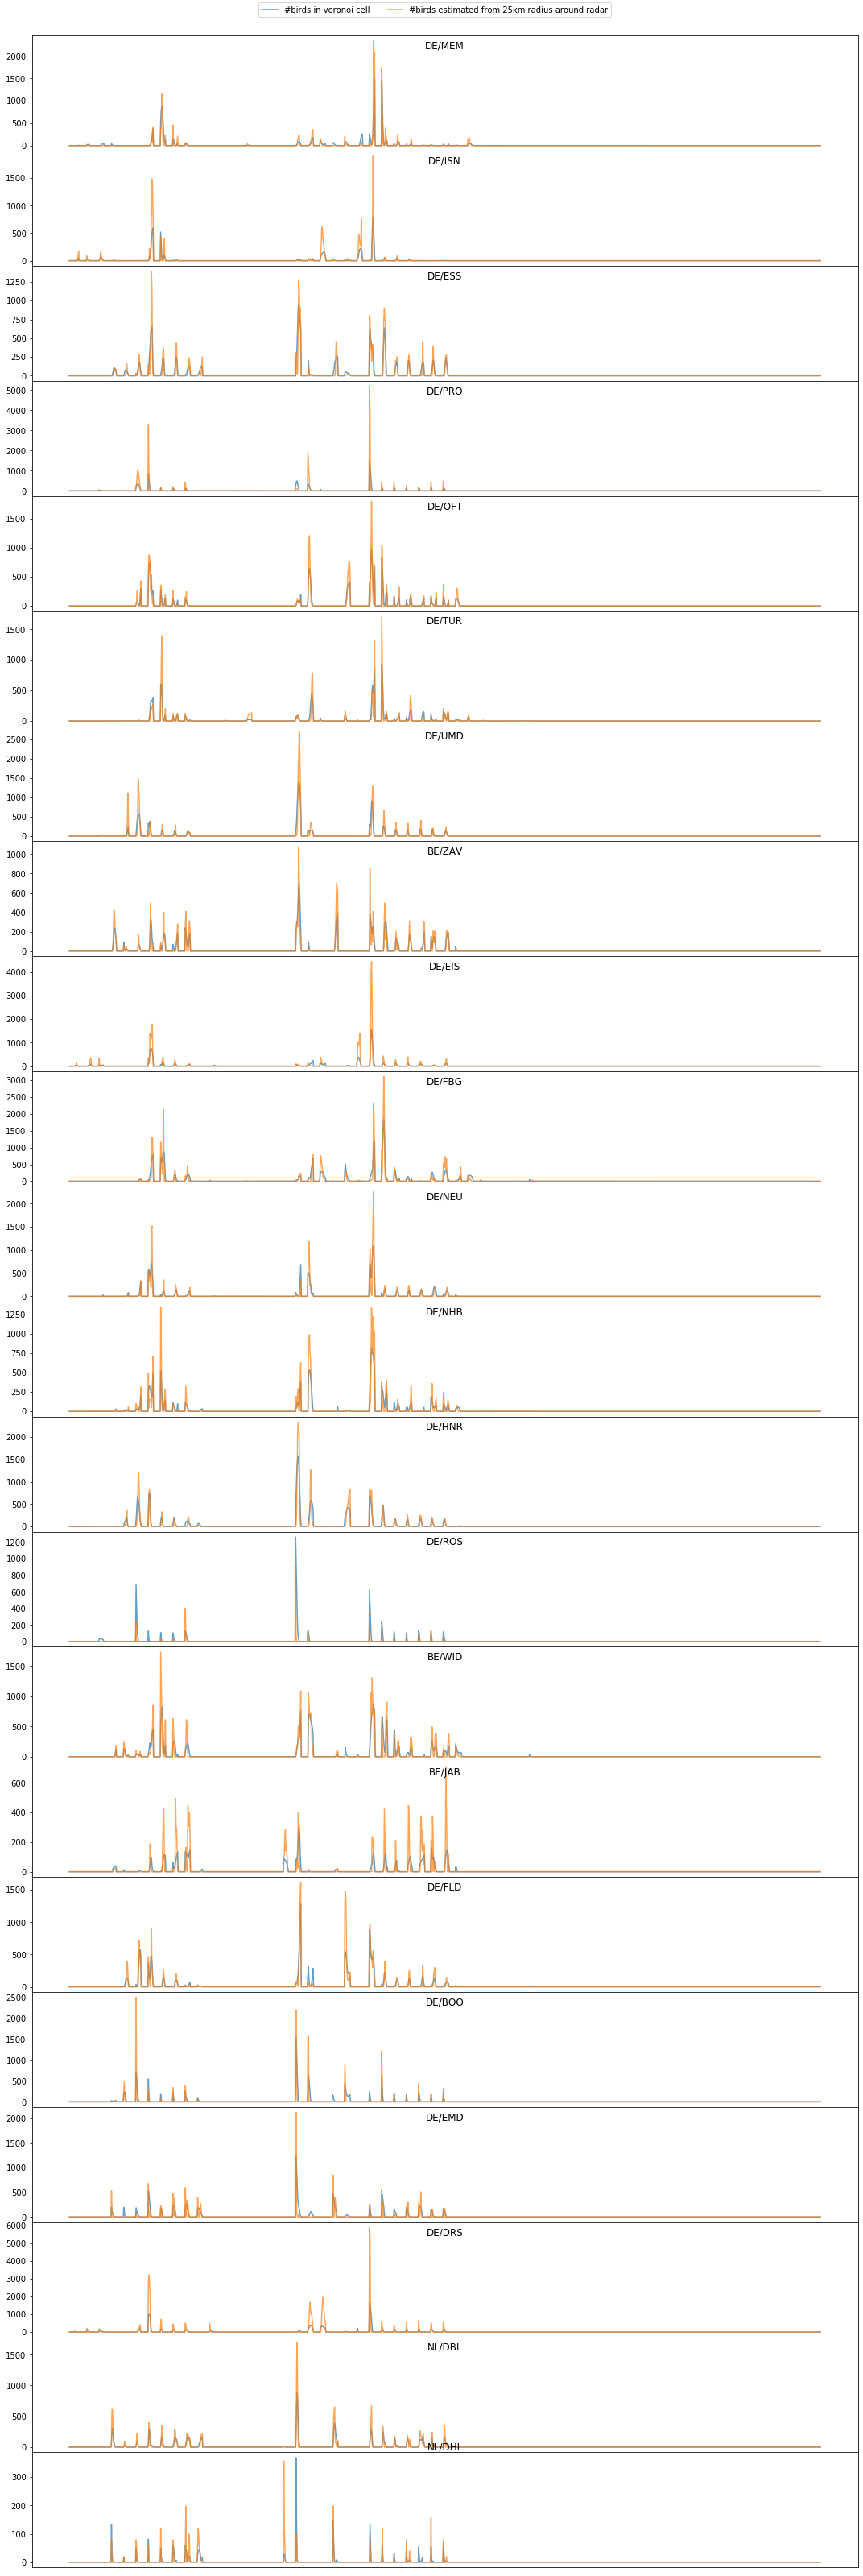

In [69]:
t_range = range(T)
fig, ax = plt.subplots(22, 1, figsize=(15,44), sharex=True)
vor_areas = voronoi.to_crs(epsg='3035').area
rad_areas = radars.to_crs(epsg='3035').area
labels = ['#birds in voronoi cell', '#birds estimated from 25km radius around radar']
n_radars = 22
for i in range(n_radars):
    vor = [counts_vor.iloc[i][f'n_birds_{t}'] for t in t_range]
    rad = [(counts_rad.iloc[i][f'n_birds_{t}'] / rad_areas.iloc[i]) * vor_areas.iloc[i] for t in t_range]
    #rad = [counts_rad.iloc[i][f'n_birds_{t}'] for t in t_range]
    #np.array(vor) - np.array(rad)
    if i == n_radars-1:
        ax[i].plot(t_range, vor, alpha=0.7, label=labels[0])
        ax[i].plot(t_range, rad, alpha=0.7, label=labels[1])
        ax[i].set_xticklabels(time)
    else:
        ax[i].plot(t_range, vor, alpha=0.7)
        ax[i].plot(t_range, rad, alpha=0.7)
        ax[i].set_xticks([])
    ax[i].set_title(counts_vor.iloc[i].radar, pad=-16)
fig.legend(loc="upper center", ncol=2, bbox_to_anchor=(0.5, 1.01))
fig.tight_layout()
fig.subplots_adjust(hspace=0)

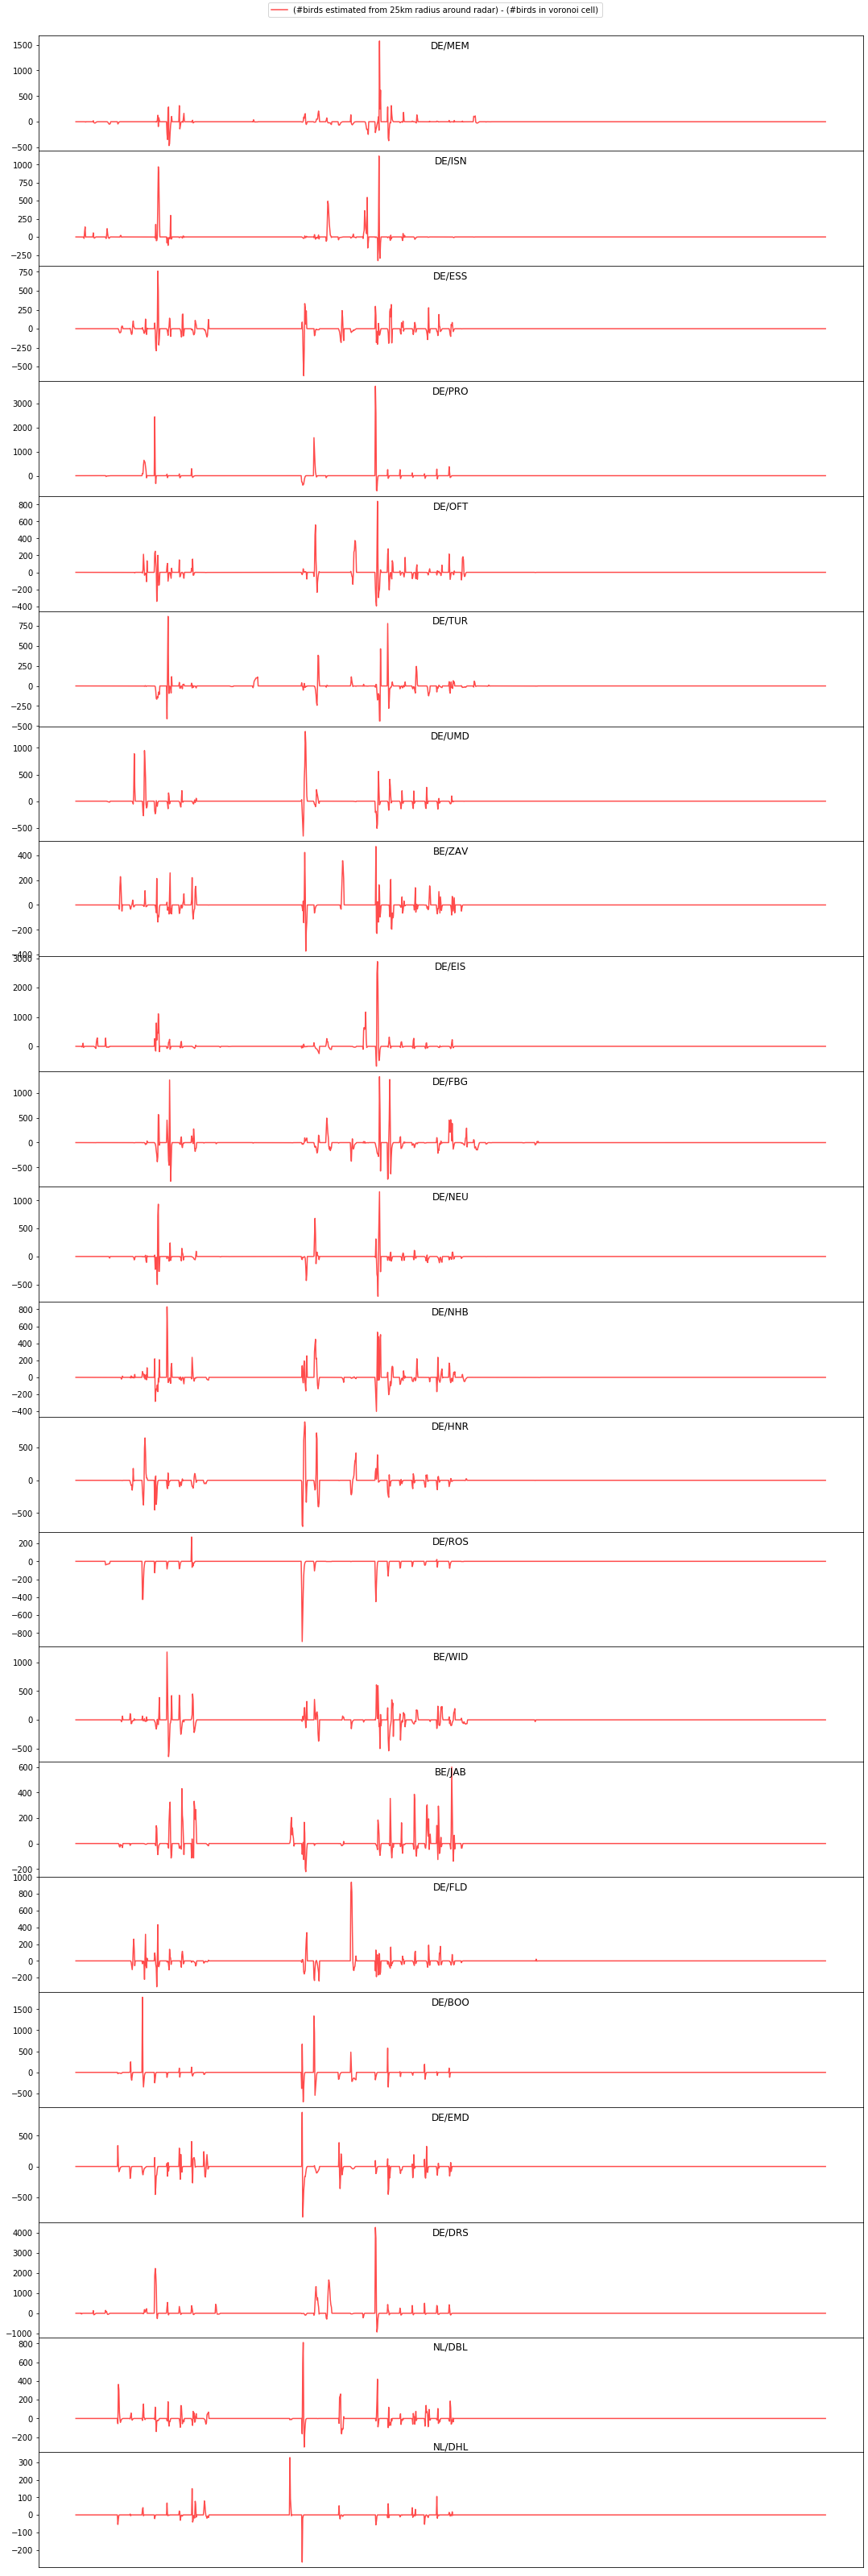

In [80]:
t_range = range(T)
fig, ax = plt.subplots(22, 1, figsize=(15,44), sharex=True)
vor_areas = voronoi.to_crs(epsg='3035').area
rad_areas = radars.to_crs(epsg='3035').area
labels = ['(#birds estimated from 25km radius around radar) - (#birds in voronoi cell)']
n_radars = 22
for i in range(n_radars):
    vor = [counts_vor.iloc[i][f'n_birds_{t}'] for t in t_range]
    rad = [(counts_rad.iloc[i][f'n_birds_{t}'] / rad_areas.iloc[i]) * vor_areas.iloc[i] for t in t_range]
    #rad = [counts_rad.iloc[i][f'n_birds_{t}'] for t in t_range]
    diff = np.array(rad) - np.array(vor)
    if i == n_radars-1:
        ax[i].plot(t_range, diff, c='red', alpha=0.7, label=labels[0])
        ax[i].set_xticklabels(time)
    else:
        ax[i].plot(t_range, diff, c='red', alpha=0.7)
        ax[i].set_xticks([])
    ax[i].set_title(counts_vor.iloc[i].radar, pad=-16)
fig.legend(loc="upper center", ncol=2, bbox_to_anchor=(0.5, 1.01))
fig.tight_layout()
fig.subplots_adjust(hspace=0)

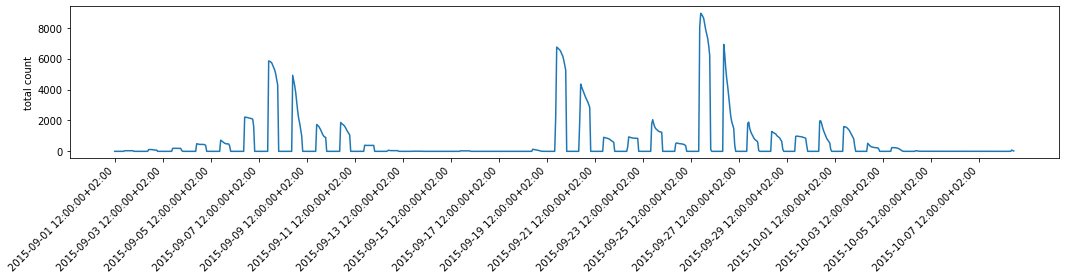

In [84]:
stop = 900
fig, ax = plt.subplots(figsize=(15,4))
ax.plot(t_range[:stop], [counts_vor[f'n_birds_{t}'].sum() for t in range(T)[:stop]])
ax.set(ylabel='total count')
plt.xticks(t_range[:stop:48], time[:stop:48], rotation=45, ha='right');
fig.tight_layout()

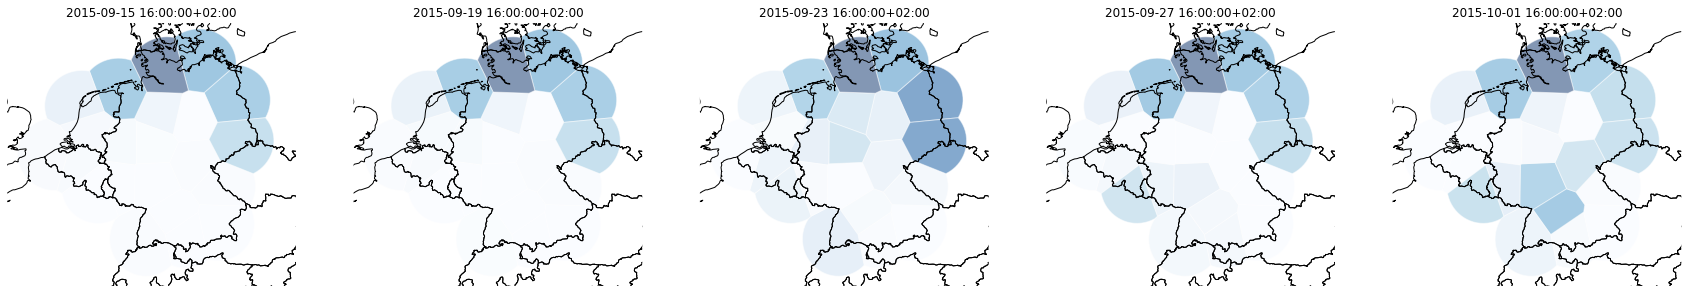

In [53]:
t_range = [100 + 10*24 + dt*24*4 for dt in range(5)]
grid = aggregate(traj, states, voronoi, t_range, state=0)

fig, axes = plt.subplots(1, 5, figsize=(30, 8), subplot_kw = {'projection' : gcrs.AlbersEqualArea()})
for i, ax in enumerate(axes):
    ax.set_title(results['time'][t_range[i]])
    ax = gplt.polyplot(
      countries,
      ax=ax,
      edgecolor="black",
      extent=extent, zorder=1
    )

    gplt.choropleth(
        grid, hue=f'n_birds_{t_range[i]}',# projection=gcrs.AlbersEqualArea(),
        edgecolor='white', linewidth=1, ax=ax, alpha=0.5, zorder=0,
        cmap='Blues', legend=False, extent=extent
    );

In [ ]:
ax = gplt.voronoi(
    injurious_collisions.head(100),
    clip=boroughs.simplify(0.001), projection=gcrs.AlbersEqualArea()
)
gplt.polyplot(boroughs, ax=ax)

In [4]:
solarposition.get_solarposition(time, 50.0, 4.2)

,apparent_zenith,zenith,apparent_elevation,elevation,azimuth,equation_of_time
2015-09-01 12:00:00+02:00,46.878266,46.896226,43.121734,43.103774,143.811092,-0.108602
2015-09-01 13:00:00+02:00,42.646264,42.661763,47.353736,47.338237,164.083566,-0.095381
2015-09-01 14:00:00+02:00,41.841372,41.856441,48.158628,48.143559,186.203662,-0.082151
2015-09-01 15:00:00+02:00,44.665687,44.682317,45.334313,45.317683,207.542912,-0.068914
2015-09-01 16:00:00+02:00,50.467059,50.487426,39.532941,39.512574,226.117319,-0.055668
...,...,...,...,...,...,...
2015-11-01 08:00:00+01:00,86.543846,86.760318,3.456154,3.239682,116.971363,16.408095
2015-11-01 09:00:00+01:00,78.618990,78.699155,11.381010,11.300845,129.168816,16.409435
2015-11-01 10:00:00+01:00,71.944804,71.995564,18.055196,18.004436,142.503313,16.410752
2015-11-01 11:00:00+01:00,67.118956,67.158449,22.881044,22.841551,157.132496,16.412045


In [7]:
ds = xr.open_dataset('/home/fiona/birdMigration/data/raw/env/fall/2015/pressure_level_850.nc')

In [6]:
pd.date_range('2015-09-02 01:00:00+00:00', '2015-09-02 05:00:00+00:00', freq='1H', tz='UTC')

DatetimeIndex(['2015-09-02 01:00:00+00:00', '2015-09-02 02:00:00+00:00',
               '2015-09-02 03:00:00+00:00', '2015-09-02 04:00:00+00:00',
               '2015-09-02 05:00:00+00:00'],
              dtype='datetime64[ns, UTC]', freq='H')

In [9]:
ds.sel(time=slice('2015-10-24 22:00:00', '2015-10-25 22:00:00')).time

<xarray.DataArray 'time' (time: 25)>
array(['2015-10-24T22:00:00.000000000', '2015-10-24T23:00:00.000000000',
       '2015-10-25T00:00:00.000000000', '2015-10-25T01:00:00.000000000',
       '2015-10-25T02:00:00.000000000', '2015-10-25T03:00:00.000000000',
       '2015-10-25T04:00:00.000000000', '2015-10-25T05:00:00.000000000',
       '2015-10-25T06:00:00.000000000', '2015-10-25T07:00:00.000000000',
       '2015-10-25T08:00:00.000000000', '2015-10-25T09:00:00.000000000',
       '2015-10-25T10:00:00.000000000', '2015-10-25T11:00:00.000000000',
       '2015-10-25T12:00:00.000000000', '2015-10-25T13:00:00.000000000',
       '2015-10-25T14:00:00.000000000', '2015-10-25T15:00:00.000000000',
       '2015-10-25T16:00:00.000000000', '2015-10-25T17:00:00.000000000',
       '2015-10-25T18:00:00.000000000', '2015-10-25T19:00:00.000000000',
       '2015-10-25T20:00:00.000000000', '2015-10-25T21:00:00.000000000',
       '2015-10-25T22:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2015-10-24T22:00:00 ... 2015-10-25T22:00:00
Attributes:
    long_name:  time

In [11]:
results['time'].size

1465

In [23]:
abm_path = '/home/fiona/birdMigration/data/experiments/abm/fall/2015/experiment_2021-02-19 15:13:36.750872'
abm_path = '/home/fiona/birdMigration/data/raw/abm/fall/2015'

traj = []
states = []
directions = []
files = glob.glob(os.path.join(abm_path, '*.pkl'))
for file in files:
    with open(file, 'rb') as f:
        results = pickle.load(f)
    traj.append(results['trajectories'])
    states.append(results['states'])
    directions.append(results['directions'])
    time = results['time']
traj = np.concatenate(traj, axis=1)
states = np.concatenate(states, axis=1)
directions = np.concatenate(directions, axis=1, dtype=np.float)
traj.shape

print(time.size)
pd.date_range(time[0], time[-1], freq='1H').size

/home/fiona/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


1465


1466

In [18]:
def extract_time(xr_dataset, freq, tz):
    time = pd.to_datetime(xr_dataset.time.values)
    time = pd.date_range(time[0], time[-1], freq=freq)
    time = time.tz_localize(tz=tz, ambiguous=False)
    return time

extract_time(ds.sel(time=slice('2015-10-24 22:00:00', '2015-10-25 22:00:00')), '1H', 'UTC')

DatetimeIndex(['2015-10-24 22:00:00+00:00', '2015-10-24 23:00:00+00:00',
               '2015-10-25 00:00:00+00:00', '2015-10-25 01:00:00+00:00',
               '2015-10-25 02:00:00+00:00', '2015-10-25 03:00:00+00:00',
               '2015-10-25 04:00:00+00:00', '2015-10-25 05:00:00+00:00',
               '2015-10-25 06:00:00+00:00', '2015-10-25 07:00:00+00:00',
               '2015-10-25 08:00:00+00:00', '2015-10-25 09:00:00+00:00',
               '2015-10-25 10:00:00+00:00', '2015-10-25 11:00:00+00:00',
               '2015-10-25 12:00:00+00:00', '2015-10-25 13:00:00+00:00',
               '2015-10-25 14:00:00+00:00', '2015-10-25 15:00:00+00:00',
               '2015-10-25 16:00:00+00:00', '2015-10-25 17:00:00+00:00',
               '2015-10-25 18:00:00+00:00', '2015-10-25 19:00:00+00:00',
               '2015-10-25 20:00:00+00:00', '2015-10-25 21:00:00+00:00',
               '2015-10-25 22:00:00+00:00'],
              dtype='datetime64[ns, UTC]', freq='H')

In [26]:
directions[directions==0] = np.nan
print(f'{np.nanmean(directions)} +- {np.nanstd(directions)}')

216.19705994993652 +- 8.034341030598195
